In [148]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor


# Barra de progreso de un proceso
# ------------------------------------------------------------------------------
from tqdm import tqdm

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

import emoji

In [101]:
df = pd.read_pickle("../datos/possum_standar_encod.pkl")

In [102]:
df.columns

Index(['case', 'site', 'age', 'hdlngth', 'skullw', 'totlngth', 'taill',
       'footlgth', 'earconch', 'eye', 'chest', 'belly', 'sex_f', 'sex_m',
       'Pop_Vic', 'Pop_other'],
      dtype='object')

# DECISION TREE

In [103]:
X = df.drop(["totlngth", 'case'], axis = 1)
y = df["totlngth"] 

In [104]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 

In [105]:
len(x_train.columns)

14

In [106]:
x_train.columns

Index(['site', 'age', 'hdlngth', 'skullw', 'taill', 'footlgth', 'earconch',
       'eye', 'chest', 'belly', 'sex_f', 'sex_m', 'Pop_Vic', 'Pop_other'],
      dtype='object')

In [107]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train) 

DecisionTreeRegressor(random_state=0)

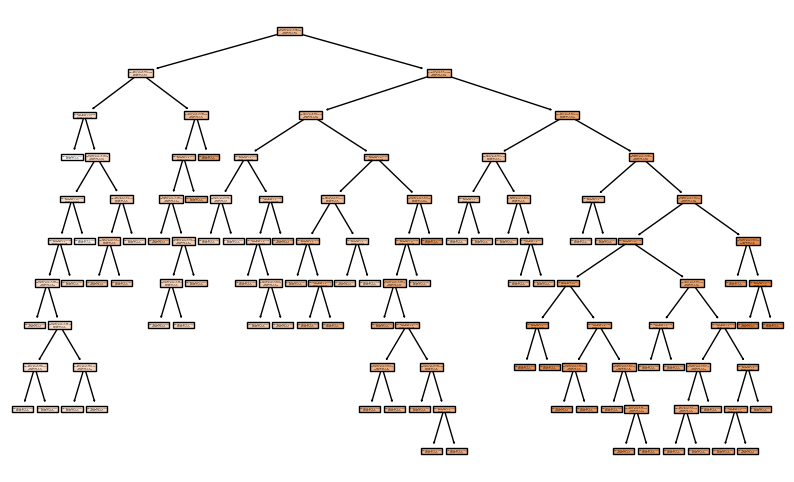

In [108]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train.columns, filled = True)
plt.show() 

In [109]:
max_features = np.sqrt(len(x_train.columns))
max_features 

3.7416573867739413

In [110]:
print(arbol.tree_.max_depth)

10


In [111]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train) 

In [112]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):


    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
        'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
        'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
        'R2': [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
        "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df 

In [113]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1 

,MAE,MSE,RMSE,R2,set,modelo
0,3.02381,13.107143,3.620379,0.001166,test,Decission Tree I
1,0.00000,0.000000,0.000000,1.000000,train,Decission Tree I


In [114]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [2,4,6,8,10], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
"max_features": [1,2,3],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
# estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
"min_samples_split": [10, 15, 20],
"min_samples_leaf": [10, 15, 20]} 

In [115]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
param_grid= param, # que hiperparámetros queremos que testee
cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
verbose=-1, # para que no nos printee ningún mensaje en pantalla
return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva 

In [116]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train, y_train) 

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 15, 20],
                         'min_samples_split': [10, 15, 20]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [117]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 6, que usa 4 variables predictoras para construir el modelo y que tiene un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo 

DecisionTreeRegressor(max_depth=8, max_features=2, min_samples_leaf=10,
                      min_samples_split=15)

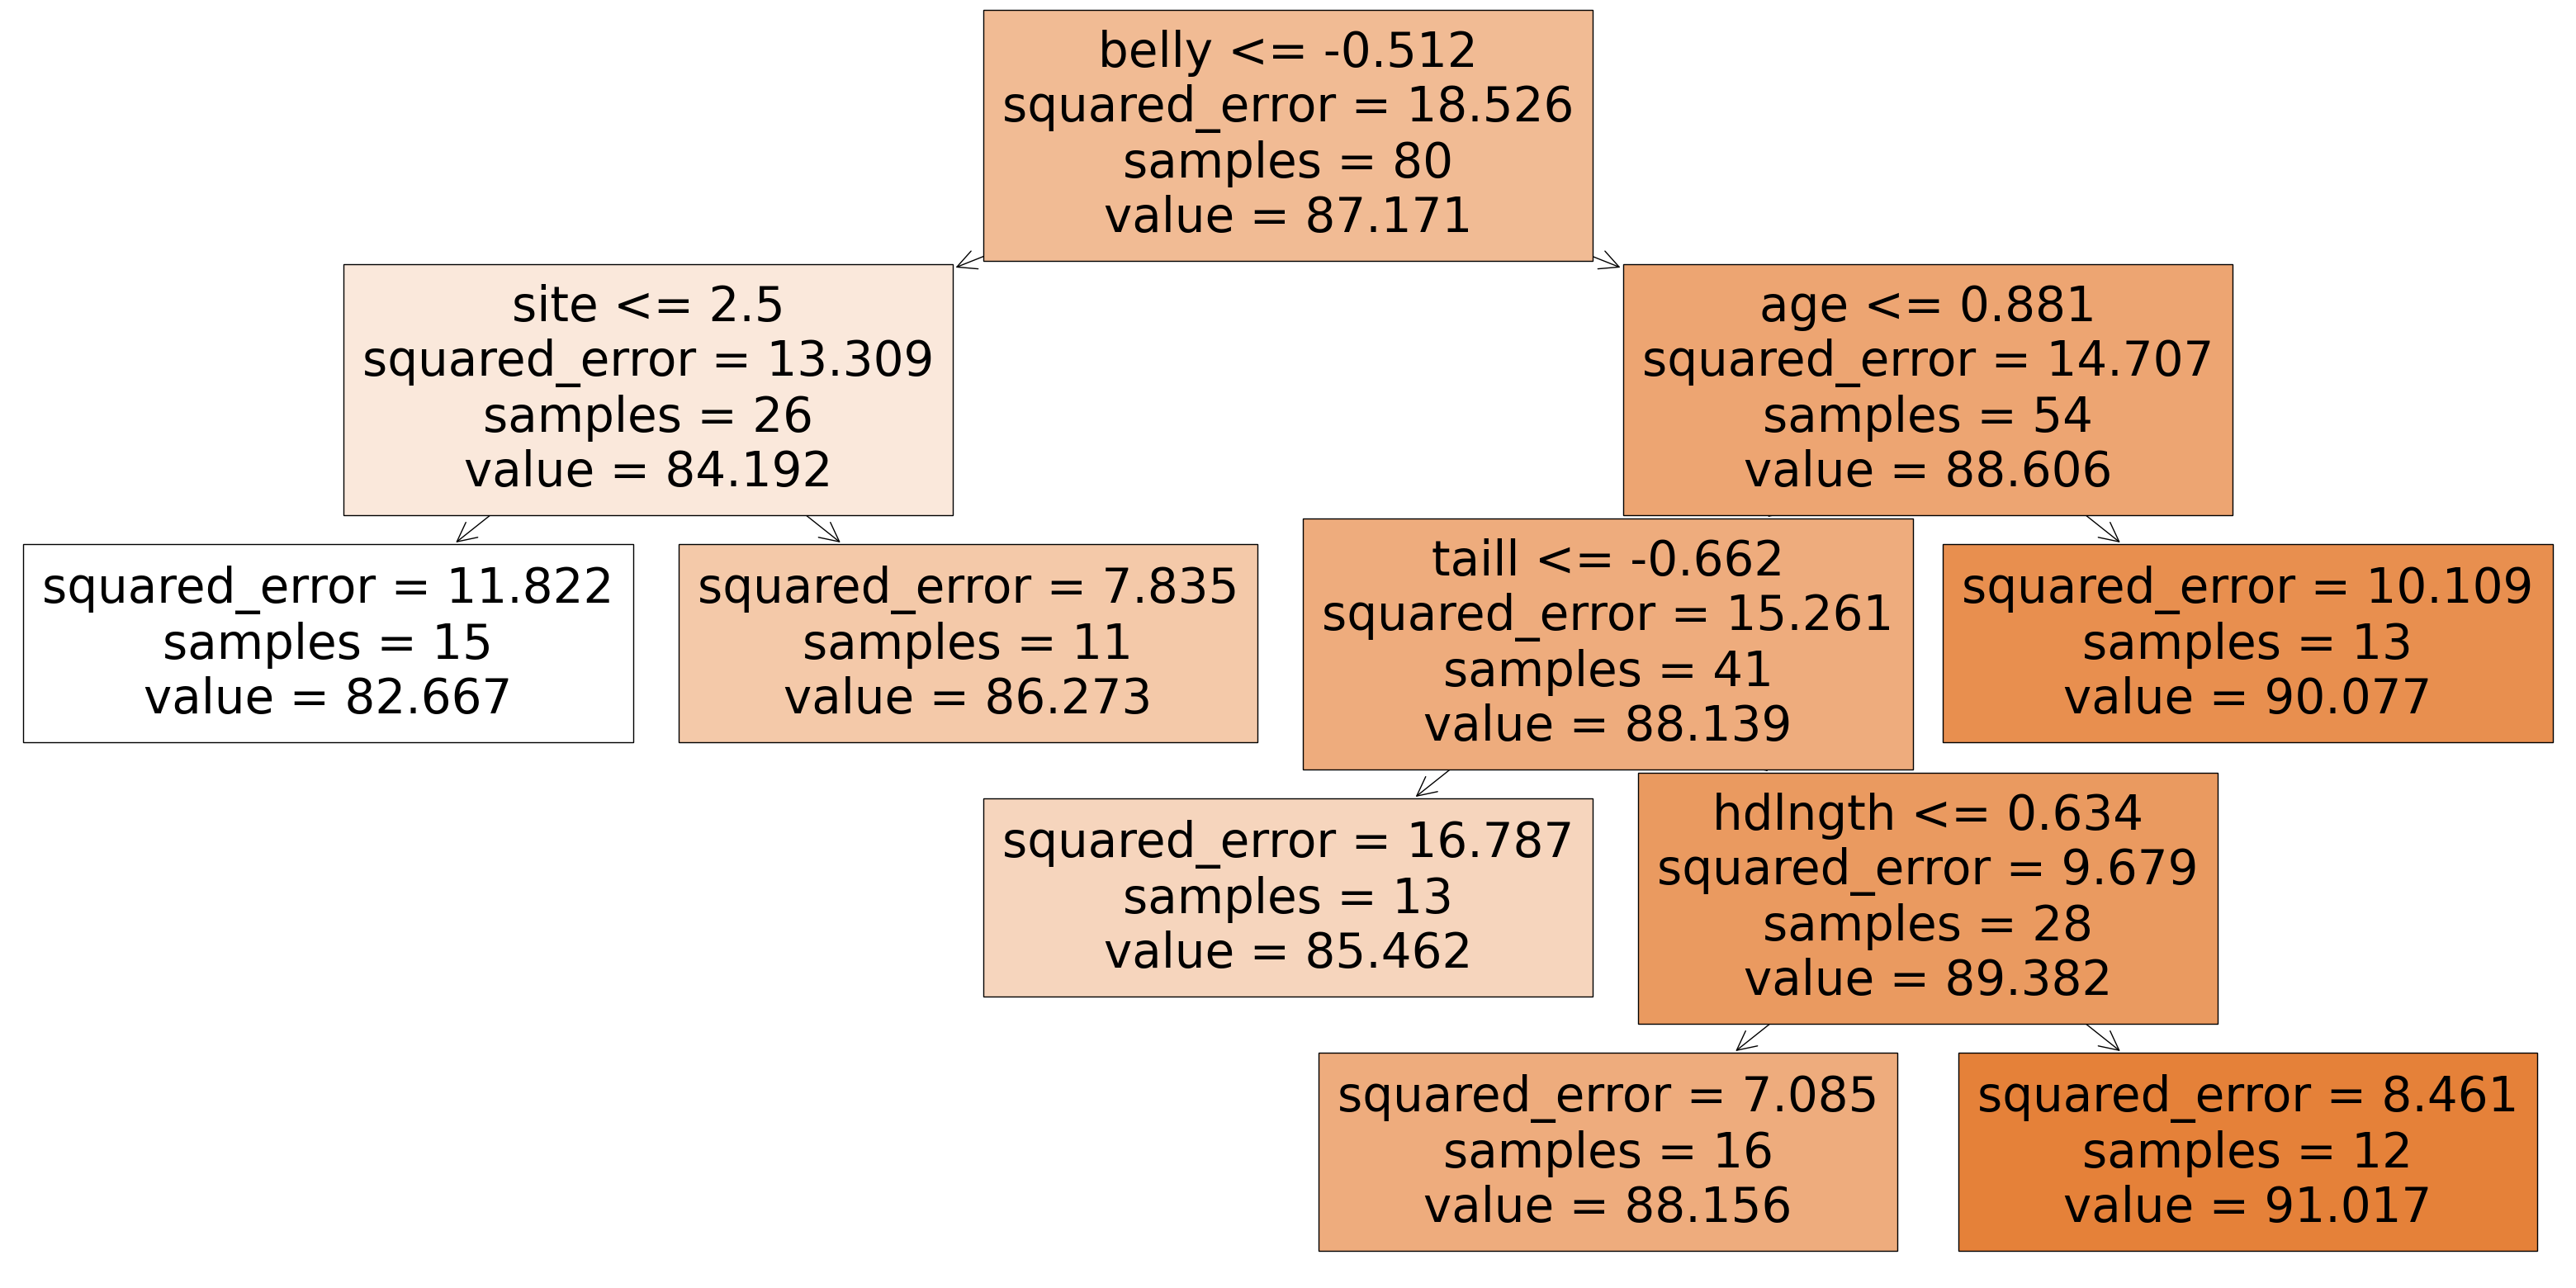

In [118]:
# veamos ahora que pinta tiene nuestro árbol


fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True); 

In [119]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [120]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2 

,MAE,MSE,RMSE,R2,set,modelo
0,2.960792,13.441306,3.666239,-0.024299,test,Decision tree II
1,2.531503,10.350813,3.217268,0.441268,train,Decision tree II


In [121]:
# vamos a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results 

,MAE,MSE,RMSE,R2,set,modelo
0,3.023810,13.107143,3.620379,0.001166,test,Decission Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decission Tree I
0,2.960792,13.441306,3.666239,-0.024299,test,Decision tree II
1,2.531503,10.350813,3.217268,0.441268,train,Decision tree II


In [122]:
df_LR_results = pd.read_csv("../datos/metricas_rlm.csv", index_col = 0)
df_LR_results 

,MAE,MSE,RMSE,R2,set,modelo
0,1.416396,3.822923,1.955230,0.708673,test,Regresión Lineal Multiple
1,1.496887,3.822772,1.955191,0.793649,train,Regresión Lineal Multiple


In [123]:
df_LR_DT = pd.concat([df_decision_results, df_LR_results], axis = 0)
df_LR_DT 

,MAE,MSE,RMSE,R2,set,modelo
0,3.023810,13.107143,3.620379,0.001166,test,Decission Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decission Tree I
0,2.960792,13.441306,3.666239,-0.024299,test,Decision tree II
1,2.531503,10.350813,3.217268,0.441268,train,Decision tree II
0,1.416396,3.822923,1.955230,0.708673,test,Regresión Lineal Multiple
1,1.496887,3.822772,1.955191,0.793649,train,Regresión Lineal Multiple


Comparamos las métricas de nuestra Regresión Lineal Múltiple con aquellas de los Decision Trees. Observamos que vuelve a pasarnos de tener over-fitting y aunque hemos intentado variar las métricas para tener un mejor ajuste, no lo hemos conseguido. 

In [124]:
# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame(
{'predictor': x_train.columns,
'importancia': mejor_modelo.feature_importances_}
)


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores 

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
9,belly,0.522673
4,taill,0.208670
0,site,0.126187
2,hdlngth,0.085790
1,age,0.056680
3,skullw,0.000000
5,footlgth,0.000000
6,earconch,0.000000
7,eye,0.000000
8,chest,0.000000


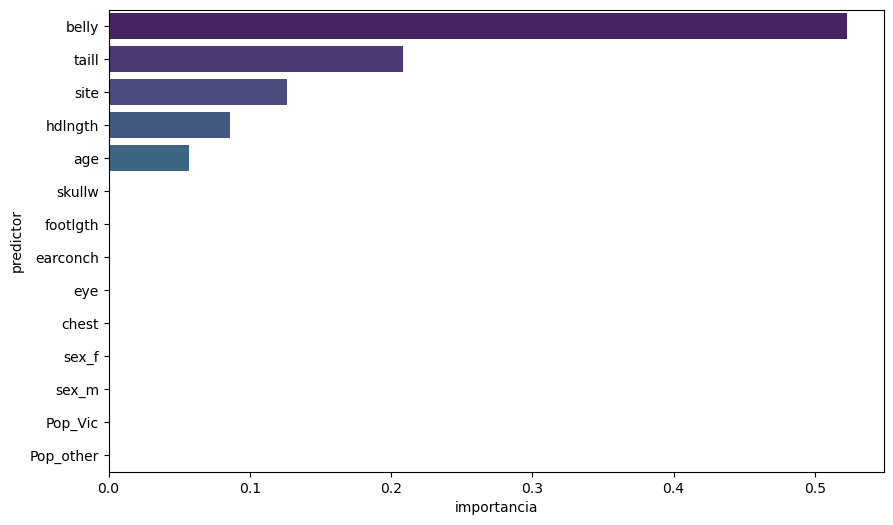

In [125]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show() 

# RANDOM FOREST

In [137]:

param = {"max_depth": [2,4,6,8, 10],
"max_features": [1,2,3],
"min_samples_split": [10, 15, 20],
"min_samples_leaf": [10, 15, 20]} 

In [138]:
gs_rf = GridSearchCV(
estimator=RandomForestRegressor(), # tipo de modelo que queremos hacer
param_grid= param, # que hiperparámetros queremos que testee
cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
verbose=-1, # para que no nos printee ningún mensaje en pantalla
return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva 

In [139]:
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 15, 20],
                         'min_samples_split': [10, 15, 20]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [140]:
bosque = gs_rf.best_estimator_
bosque 

RandomForestRegressor(max_depth=8, max_features=3, min_samples_leaf=10,
                      min_samples_split=15)

In [141]:
# for arbol in tqdm(bosque.estimators_):
#   fig = plt.figure(figsize=(40, 20))
#   tree.plot_tree(arbol, feature_names= x_train.columns, filled = True)
#   plt.show() 

In [142]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [143]:
# Ahora vamos a calcular las métricas 
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
    'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
    'R2': [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
    "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df 

In [144]:

rf_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
rf_results 

,MAE,MSE,RMSE,R2,set,modelo
0,2.035078,7.191488,2.681695,0.451971,test,Random Forest
1,2.135748,6.798364,2.607367,0.633028,train,Random Forest


In [145]:

df_LR_DT_RF = pd.concat([df_LR_DT, rf_results], axis=0)
df_LR_DT_RF 

,MAE,MSE,RMSE,R2,set,modelo
0,3.023810,13.107143,3.620379,0.001166,test,Decission Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decission Tree I
0,2.960792,13.441306,3.666239,-0.024299,test,Decision tree II
1,2.531503,10.350813,3.217268,0.441268,train,Decision tree II
0,1.416396,3.822923,1.955230,0.708673,test,Regresión Lineal Multiple
1,1.496887,3.822772,1.955191,0.793649,train,Regresión Lineal Multiple
0,2.035078,7.191488,2.681695,0.451971,test,Random Forest
1,2.135748,6.798364,2.607367,0.633028,train,Random Forest


Aunque hemos ido variando los parámetros para intentar tenes un mejor ajuste, no logramos deshacernos del over-fitting. Es probable que debido a la falta de datos, no podamos ajustar un buen modelo. 

In [146]:
importancia_predictores = pd.DataFrame(
{'predictor': x_train.columns,
'importancia': bosque.feature_importances_}
)


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,site,0.191806
3,skullw,0.176386
2,hdlngth,0.176166
4,taill,0.144470
8,chest,0.088381
9,belly,0.066300
5,footlgth,0.063150
7,eye,0.042953
11,sex_m,0.014864
6,earconch,0.013881


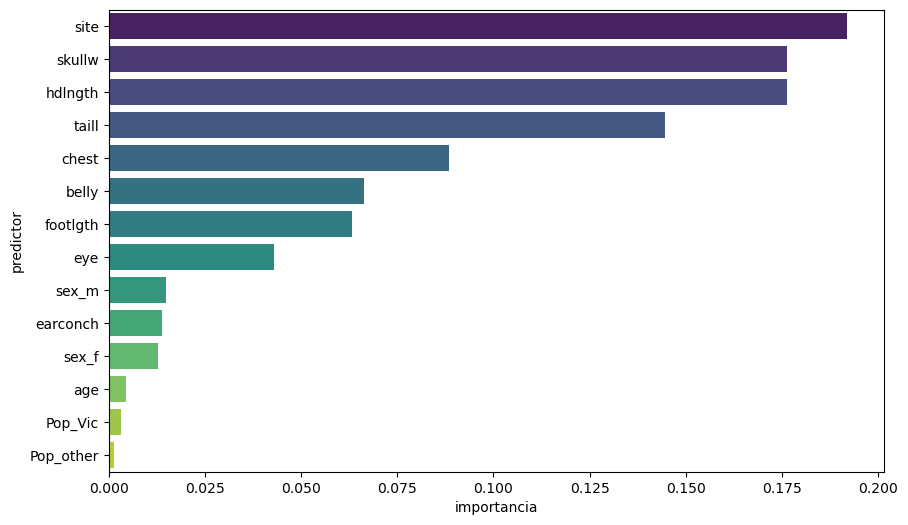

In [147]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show() 

Al igual que vimos durante el EDA, parecer ser que las variables de 'site', 'skullw', 'hglngth' y 'taill' juegan un papel importante a la hora de predecir el largo total del cuerpo de las zarigüeyas. 

Nuestra conclusión final es que para poder generar un buen modelo, necesitaríamos un dataset más grande. No queda otra que volver al campo a medir zarigüeyas 🧐.